# Подготовим данные для обучении модели,заполним пропуски и создадим новые фичи

## Импорт библиотек

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import mlflow
import sklearn 
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import mlflow.sklearn, mlflow.xgboost, mlflow.lightgbm, mlflow.catboost

### Считывание данных 

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
data = df.copy()
df_train,df_test = train_test_split(data,test_size=0.2,random_state=42)

## Повторим все манипуляции над данным из файла eda.ipynb,а также поэкспрементируем с новыми фичами

## Переведем колонки cylinders и posting_date в другие форматы,для более удобной работы с ними в дальнейшем

In [4]:
# Преобразование цилиндров
df_train['cylinders_num'] =  df_train['cylinders'].str.extract('(\d+)')
df_train['cylinders_num'] = df_train['cylinders_num'].astype(float)



# Создание новых числовых признаков
df_train['posting_date'] = pd.to_datetime(df_train['posting_date'], errors='coerce', utc=True)
df_train['posting_year'] = df_train['posting_date'].dt.year
df_train['posting_month'] = df_train['posting_date'].dt.month
df_train['posting_day'] = df_train['posting_date'].dt.day
df_train['posting_weekday'] = df_train['posting_date'].dt.weekday  
df_train['posting_hour'] = df_train['posting_date'].dt.hour

df_train.drop(columns=['posting_date','posting_year','cylinders'],inplace=True)


df_test['cylinders_num'] = df_test['cylinders'].str.extract('(\d+)')
df_test['cylinders_num'] = df_test['cylinders_num'].astype(float)


df_test['posting_date'] = pd.to_datetime(df_test['posting_date'], errors='coerce', utc=True)
df_test['posting_year'] = df_test['posting_date'].dt.year
df_test['posting_month'] = df_test['posting_date'].dt.month
df_test['posting_day'] = df_test['posting_date'].dt.day
df_test['posting_weekday'] = df_test['posting_date'].dt.weekday
df_test['posting_hour'] = df_test['posting_date'].dt.hour

# Удалим год публикации для того,чтобы не создавать шума в данных 
df_test.drop(columns=['posting_date','posting_year','cylinders'], inplace=True)

## Удалим колонки с большим количеством уникальных значений

In [5]:
df_train.drop(columns=['id', 'url', 'image_url', 'region_url','VIN'],inplace=True)
df_test.drop(columns=['id', 'url', 'image_url', 'region_url','VIN'],inplace=True)

##  Удалим неинформативные столбцы  из обучающей выборки

In [6]:
def find_col_to_del(data:pd.DataFrame):
    all_k = data.shape[0]
    cols_with_null = data.columns[data.isnull().sum() > 0].tolist()
    cols_to_drop = []
    for col in cols_with_null:
        if (data[col].isnull().sum() / all_k) * 100 > 70:
            cols_to_drop.append(col)
    return cols_to_drop

cols_to_drop = find_col_to_del(data=df_train)
df_train.drop(columns=cols_to_drop,inplace=True)
df_test.drop(columns=cols_to_drop,inplace=True)

## Аналогично поступим и со строками

In [7]:
df_train = df_train.dropna(thresh=int((df_train.shape[1] / 100) * 70))

## Удалим выбросы

### Для начала уберем явные выбросы

In [8]:
df_train = df_train[(df_train['price'] <= 500_000) & (df_train['price'] >= 100)]
df_train = df_train[df_train['odometer'] <= 600_000]

df_test = df_test[(df_test['price'] <= 500_000) & (df_test['price'] >= 100)]
df_test = df_test[df_test['odometer'] <= 600_000]

###  Для более объективного и воспроизводимого отбора выбросов я применю метод IQR с кастомными квантилями. Это позволит формально выделить аномалии и гибко настроить границы через коэффициент k, избегая чрезмерного удаления данных.

In [9]:
def delete_by_IQR(data: pd.DataFrame, column: str, q_low: float = 0.25, q_high: float = 0.75) -> None:
    if column not in data.columns:
        print(f"Колонка '{column}' не найдена в DataFrame")
    
    else:
        Q1 = data[column].quantile(q_low)
        Q3 = data[column].quantile(q_high)
        IQR = Q3 - Q1

        low_border = Q1 - 1.5 * IQR
        high_border = Q3 + 1.5 * IQR

        before = len(data)
        data.drop(data[(data[column] < low_border) | (data[column] > high_border)].index, inplace=True)
        after = len(data)
        print(f"'{column}': удалено {before - after} выбросов")


df_train_clean = df_train.copy()
for col in ['year', 'price', 'odometer','long','lat']:
    delete_by_IQR(df_train_clean, col, q_low=0.1, q_high=0.90)

'year': удалено 5932 выбросов
'price': удалено 674 выбросов
'odometer': удалено 250 выбросов
'long': удалено 18 выбросов
'lat': удалено 45 выбросов


### Посторим на размер датасета после всех удалений

In [10]:
print('Размер датасета: ',df_train_clean.shape)

Размер датасета:  (302707, 22)


## Заполним пропуски

#### Числовые 

In [11]:
def find_num_col_to_fill(data: pd.DataFrame):
    num_cols = data.select_dtypes(exclude=['object'])
    num_cols_with_null = num_cols.columns[num_cols.isnull().any()].tolist()
    return  num_cols_with_null

num_cols_to_fil = list(set(find_num_col_to_fill(df_train_clean) + find_num_col_to_fill(df_test)))

df_train_clean[num_cols_to_fil] = df_train_clean[num_cols_to_fil].fillna(df_train_clean[num_cols_to_fil].mean())
df_test[num_cols_to_fil] = df_test[num_cols_to_fil].fillna(df_train_clean[num_cols_to_fil].mean())

In [12]:

print(num_cols_to_fil)

['long', 'year', 'lat', 'cylinders_num']


#### Категориальные 

In [13]:
def find_cat_col_to_fill(data: pd.DataFrame):
    cat_cols = data.select_dtypes(include=['object'])
    cat_cols_with_null = [col for col in cat_cols.columns if cat_cols[col].isnull().any() and col != 'description']
    return cat_cols_with_null

cat_cols_to_fill = list(set(find_cat_col_to_fill(df_train_clean) + find_cat_col_to_fill(df_test)))


df_train_clean[cat_cols_to_fill] = df_train_clean[cat_cols_to_fill].fillna('unknown').astype(str)
df_test[cat_cols_to_fill] = df_test[cat_cols_to_fill].fillna('unknown').astype(str)


## Выделим наиболее встречающиеся значения в колнках region и model 

### Region

In [14]:
region_counts = df_train_clean['region'].value_counts()
top100 = region_counts.head(100)
df_train_clean['region_top100'] = df_train_clean['region'].apply(lambda x: x if x in top100.index else 'Other')
df_test['region_top100'] = df_test['region'].apply(lambda x: x if x in top100.index else 'Other')
df_train_clean.drop(columns = ['region'],inplace = True)
df_test.drop(columns = ['region'],inplace = True)

### Model

In [15]:
model_counts = df_train_clean['model'].value_counts()
top250 = model_counts.head(250)
df_train_clean['model_top250'] = df_train_clean['model'].apply(lambda x: x if x in top250.index else 'Other')
df_test['model_top250'] = df_test['model'].apply(lambda x: x if x in top250.index else 'Other')
df_train_clean.drop(columns = ['model'],inplace = True)
df_test.drop(columns = ['model'],inplace = True)

## Добавим новые признаки

In [16]:
def create_features_optimized(data, num_columns=[]):
    """Функция для создания новых фич"""
    
    for col in num_columns:
        if col not in ['price', 'lat', 'long']:
            data[f'log_{col}'] = np.log1p(data[col])
    
    data['car_age'] = 2021 - data['year']
    
    car_age_safe = data['car_age'].replace(0, 1)
    data['mileage_per_year'] = data['odometer'] / car_age_safe
    
    if len(data) > 0:
        data['region_lat_bin'] = pd.qcut(data['lat'], q=10, labels=False, duplicates='drop')
        data['region_long_bin'] = pd.qcut(data['long'], q=10, labels=False, duplicates='drop')
        data['lat_long_cluster'] = (data['region_lat_bin'] * 10 + data['region_long_bin']).astype(int)
    
    if 'description' in data.columns:
        descriptions = data['description'].fillna('')
        data['len_description'] = descriptions.str.len()
        data['word_count'] = [len(str(desc).split()) for desc in descriptions]
    
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].replace([np.inf, -np.inf], 0).fillna(0)
    
    data.drop(columns=['lat', 'long'], inplace=True, errors='ignore')

    return data

In [17]:
num_cols = df_train_clean.select_dtypes(exclude='object').columns
df_train_clean = create_features_optimized(df_train_clean,num_cols)
print('train обработан')
df_test = create_features_optimized(df_test,num_cols)
print('test обраотан')

train обработан
test обраотан


# Выбор наилучшей стратегии

### Сравнивая метрики моделей, обученных на baseline, можно оценить эффективность внесённых изменений в признаки и модель.

### Для начала напишем функцию для энкодинга категориальных признаков 

In [18]:
def prepare_features(X_train, X_test, categorical_features, method='label_encode'):
    """
    Подготовка признаков в зависимости от метода
    """
    if method == 'label_encode':
        X_train_encoded = X_train.copy()
        X_test_encoded = X_test.copy()
        
        for col in categorical_features:
            encoder = LabelEncoder()
            combined = pd.concat([X_train[col], X_test[col]])
            encoder.fit(combined)
            X_train_encoded[col] = encoder.transform(X_train[col])
            X_test_encoded[col] = encoder.transform(X_test[col])
            
        return X_train_encoded, X_test_encoded
    
    elif method == 'native':
        X_train_native = X_train.copy()
        X_test_native = X_test.copy()
        
        for col in categorical_features:
            X_train_native[col] = X_train_native[col].astype('category')
            X_test_native[col] = X_test_native[col].astype('category')
            
        return X_train_native, X_test_native
    
    return X_train, X_test

### Далее напишем функцию для обучени всех нами выбранных моделей из baseline

### Добввыить вал выборку

In [20]:
def train_models_simple(configs_models, X_train, X_test, y_train, y_test, cat_features,name_update:str):
    """Функция для обучения на базовых признаках"""
    
    X_train_encode, X_test_encode = prepare_features(X_train, X_test, cat_features, method='label_encode')
    X_train_native, X_test_native = prepare_features(X_train, X_test, cat_features, method='native')

    for model_config in configs_models:
        model_name = model_config["name"] + name_update
        print(f"Обучаем модель: {model_name}")

        with mlflow.start_run(run_name=model_name):
            
            model = model_config['model_class'](**model_config['params'])
            encoding_type = model_config["encoding"]

            if encoding_type == "label_encode":
                model.fit(X_train_encode, y_train)
                y_pred = model.predict(X_test_encode)
            else:
                if isinstance(model, CatBoostRegressor):
                    model.fit(X_train_native, y_train, cat_features=cat_features)
                else:
                    model.fit(X_train_native, y_train, categorical_feature=cat_features)
                y_pred = model.predict(X_test_native)
            
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            # Логируем  параметры и метрики
            mlflow.log_params(model_config['params'])
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("R2", r2)
            mlflow.log_param("encoding_type", encoding_type)
            mlflow.log_param("model_name", model_name)
            mlflow.log_param("n_train", len(X_train))
            mlflow.log_param("n_test", len(X_test))
            

            print(f"Результаты модели {model_name}: MAE:{mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


### Модернезируем нашу функцию для обучения моделей с помощью добавления TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import mlflow
import numpy as np
import pandas as pd

def train_models_with_TF_IDF(configs_models, X_train, X_test, y_train, y_test, cat_features, name_update: str):
    """Функция для обучения моделей, включая TF-IDF преобразование текстового признака 'description'"""

    X_train_encode, X_test_encode = prepare_features(X_train, X_test, cat_features, method='label_encode')

    if 'description' in X_train.columns:
        print("Выполняем TF-IDF преобразование признака 'description'...")
        tfidf = TfidfVectorizer(
            max_features=500,
            stop_words='english',
            ngram_range=(1, 2)
        )

        X_train_tfidf = tfidf.fit_transform(X_train['description'].fillna(''))
        X_test_tfidf = tfidf.transform(X_test['description'].fillna(''))


        X_train_encode = X_train_encode.drop(columns=['description'], errors='ignore')
        X_test_encode = X_test_encode.drop(columns=['description'], errors='ignore')


        X_train_final = hstack([csr_matrix(X_train_encode.values), X_train_tfidf])
        X_test_final = hstack([csr_matrix(X_test_encode.values), X_test_tfidf])
    else:
        print("Поле 'description' не найдено, TF-IDF не применяется.")
        X_train_final = csr_matrix(X_train_encode.values)
        X_test_final = csr_matrix(X_test_encode.values)


    for model_config in configs_models:
        model_name = model_config["name"] + name_update
        print(f"\nОбучаем модель: {model_name}")

        with mlflow.start_run(run_name=model_name):
            model = model_config['model_class'](**model_config['params'])
            encoding_type = model_config["encoding"]

            model.fit(X_train_final, y_train)

            y_pred = model.predict(X_test_final)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            mlflow.log_params(model_config['params'])
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("R2", r2)
            mlflow.log_param("encoding_type", encoding_type)
            mlflow.log_param("model_name", model_name)
            mlflow.log_param("n_train", len(X_train))
            mlflow.log_param("n_test", len(X_test))

            print(f"Результаты модели {model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

### Напишем функцию для получения конфигов модели

In [22]:
def get_model_configs(cat_features):
    """Все настройки моделей в одном месте"""
    return [
        {
            'name': 'RandomForest',
            'model_class': RandomForestRegressor,
            'encoding': 'label_encode',
            'cat_features': cat_features,
            'params': {
                'n_estimators': 100,
                'max_depth': 16,
                'min_samples_leaf': 3,
                'max_features': 'sqrt',
                'n_jobs': -1,
                'random_state': 42,
                'verbose': 1
            }
        },
        {
            'name': 'CatBoost',
            'model_class': CatBoostRegressor,
            'encoding': 'native',
            'cat_features': cat_features,
            'params': {
                'n_estimators': 1000,
                'learning_rate': 0.05,
                'depth': 6,
                'loss_function': 'MAE',
                'eval_metric': 'MAE',
                'random_seed': 42,
                'verbose': False,
                'early_stopping_rounds': 100
            }
        },
        {
            'name': 'LightGBM',
            'model_class': LGBMRegressor,
            'encoding': 'native',
            'cat_features': cat_features,
            'params': {
                'n_estimators': 1000,
                'learning_rate': 0.05,
                'max_depth': -1,
                'random_state': 42,
                'verbose': -1
            }
        },
        {
            'name': 'XGBoost',
            'model_class': XGBRFRegressor,
            'encoding': 'label_encode',
            'cat_features': cat_features,
            'params': {
                'n_estimators': 1000,
                'max_depth': 12,
                'random_state': 42
            }
        }
    ]

## Тест моделей

### Для начала получим категориальные признаки и разобъем на признаки и целевую переменную

In [23]:
cat_features = df_train_clean.select_dtypes(include='object').columns.tolist()

X_train = df_train_clean.drop(columns = ['price'])
y_train = df_train_clean['price']
X_test = df_test.drop(columns = ['price'])
y_test = df_test['price']

### Обучим модели

In [ ]:
mlflow.set_experiment("Car Price Prediction")


train_models_with_TF_IDF(get_model_configs(cat_features), X_train, X_test, y_train, y_test, cat_features,'_with_new_features_and_TF_IDF')

Выполняем TF-IDF преобразование признака 'description'...

Обучаем модель: RandomForest_with_new_features_and_TF_IDF


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


Результаты модели RandomForest_with_new_features_and_TF_IDF: MAE=3807.8526, RMSE=7510.9739, R²=0.7578

Обучаем модель: CatBoost_with_new_features_and_TF_IDF
Результаты модели CatBoost_with_new_features_and_TF_IDF: MAE=3576.4681, RMSE=7578.1165, R²=0.7534

Обучаем модель: LightGBM_with_new_features_and_TF_IDF


/opt/anaconda3/envs/mlflow-env/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Результаты модели LightGBM_with_new_features_and_TF_IDF: MAE=2974.3822, RMSE=6271.6176, R²=0.8311

Обучаем модель: XGBoost_with_new_features_and_TF_IDF


## Проанализируем все эксперименты

### Получим результаты

In [3]:
experiment_name = "Car Price Prediction"

experiment = mlflow.get_experiment_by_name(experiment_name)

runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

### Визуализируем их

### MAE

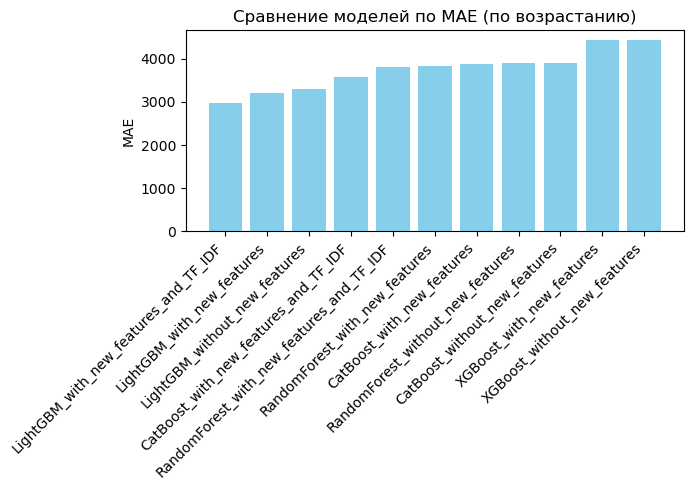

In [4]:

runs_sorted = runs.sort_values('metrics.MAE', ascending=True)

plt.figure(figsize=(7,5))
plt.bar(runs_sorted['tags.mlflow.runName'], runs_sorted['metrics.MAE'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("Сравнение моделей по MAE (по возрастанию)")
plt.tight_layout()
plt.show()

### R2

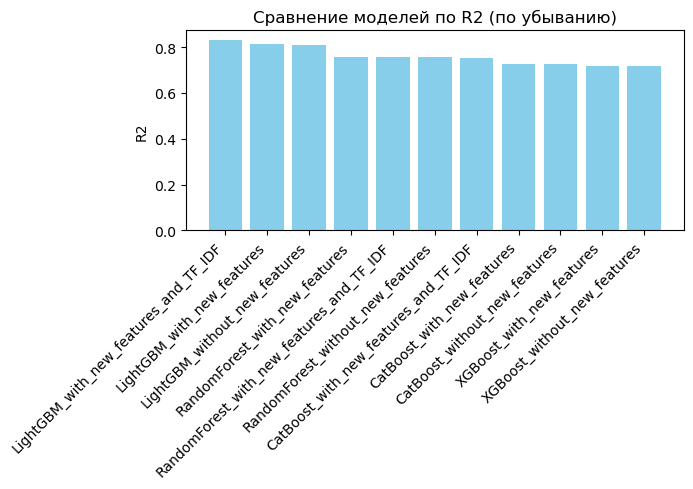

In [5]:
runs_sorted = runs.sort_values('metrics.R2',ascending=False)

plt.figure(figsize=(7,5))
plt.bar(runs_sorted['tags.mlflow.runName'], runs_sorted['metrics.R2'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("R2")
plt.title("Сравнение моделей по R2 (по убыванию)")
plt.tight_layout()
plt.show()

### RMSE

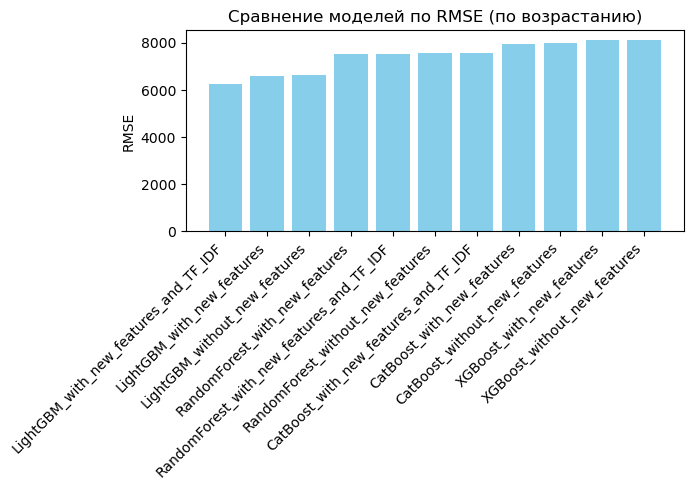

In [6]:
runs_sorted = runs.sort_values('metrics.RMSE',ascending=True)

plt.figure(figsize=(7,5))
plt.bar(runs_sorted['tags.mlflow.runName'], runs_sorted['metrics.RMSE'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Сравнение моделей по RMSE (по возрастанию)")
plt.tight_layout()
plt.show()

## Вывод

### На основе полученных результатов можно сделать вывод, что все применённые преобразования данных и добавленные признаки значительно улучшили качество моделей — метрики заметно улучшились по сравнению с baseline. Среди всех моделей наилучшие результаты по всем ключевым метрикам показала LightGBM. Именно она выбрана в качестве основной модели, поскольку после всех экспериментов её показатели существенно превосходят результаты baseline-модели.